### Understanding Batch Norm

- Batch norm is a training stabilization technique that centers and normalizes the layer's input, which in turn makes the training stable and more faster.

Why do we need this?

Imagine a network that's 5 layers deep. You normalize the input data and pass it through the first layer. From layer 1 to 5, the activations/features are constantly changing, in some case they might be quite large in other cases quite skewed. Each layer's objective is only to take the input and help in predicting the corresponding output. Now if these activations keep varying too much, the neurons find it difficult to learn the patterns. This is where batch norm comes in clutch.


This aids in a phenomenon called the **covariant shift**, where refers to the change in the distribution of network activations due to the updating of network parameters during training.


#### Algorithm

1. Create mini-batches.
2. During training, calculate the mean and variance of each mini-batch.
3. Use this to normalize the current mini-batch.
4. Pretty neat, but we have two more learnable parameters ---> γ gamma β beta
5. These parameters are learned during the training and this allow the layer to either undo the normalization or to manipulate it in any way beneficial for the model and training.


There's one more added advantage here, since you normalize with the statistics of the current mini-batch for each activations, there is some noise added in which acts as a sort of regularization.


#### During test time

Since we don't have mini-batches anymore, how do you infer on single image?

1. Keep a track of the running mean and variance during training.
2. Use the running average to do the normalization over the test image and infer :)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
class CNNWithBatchNorm(nn.Module):
    def __init__(self):
        super(CNNWithBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.bn1(torch.relu(self.conv1(x)))
        x = nn.MaxPool2d(2)(x)
        x = self.bn2(torch.relu(self.conv2(x)))
        x = nn.MaxPool2d(2)(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.bn3(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

class CNNWithoutBatchNorm(nn.Module):
    def __init__(self):
        super(CNNWithoutBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = nn.MaxPool2d(2)(x)
        x = torch.relu(self.conv2(x))
        x = nn.MaxPool2d(2)(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def train_model(model, optimizer, criterion, train_loader, test_loader, device, epochs=5):
    model.to(device)
    train_accuracies = []
    test_accuracies = []
    losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        losses.append(running_loss / len(train_loader))
        
        # Test accuracy
        model.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")
    
    return train_accuracies, test_accuracies, losses

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train the model with Batch Normalization
print("Training model with Batch Normalization:")

model_with_bn = CNNWithBatchNorm()
optimizer_with_bn = optim.Adam(model_with_bn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_acc_with_bn, test_acc_with_bn, _ = train_model(
    model_with_bn, optimizer_with_bn, criterion, train_loader, test_loader, device
)

model_without_bn = CNNWithoutBatchNorm()
optimizer_without_bn = optim.Adam(model_without_bn.parameters(), lr=0.001)

# Train the model without Batch Normalization
print("\nTraining model without Batch Normalization:")
train_acc_without_bn, test_acc_without_bn, _ = train_model(
    model_without_bn, optimizer_without_bn, criterion, train_loader, test_loader, device
)

Training model with Batch Normalization:
Epoch 1/5, Loss: 1.1294, Train Accuracy: 59.90%, Test Accuracy: 67.34%
Epoch 2/5, Loss: 0.7666, Train Accuracy: 73.20%, Test Accuracy: 72.06%
Epoch 3/5, Loss: 0.5897, Train Accuracy: 79.23%, Test Accuracy: 72.54%
Epoch 4/5, Loss: 0.4372, Train Accuracy: 85.19%, Test Accuracy: 73.13%
Epoch 5/5, Loss: 0.3006, Train Accuracy: 90.08%, Test Accuracy: 73.59%

Training model without Batch Normalization:
Epoch 1/5, Loss: 1.4175, Train Accuracy: 49.30%, Test Accuracy: 59.23%
Epoch 2/5, Loss: 1.0609, Train Accuracy: 62.39%, Test Accuracy: 65.21%
Epoch 3/5, Loss: 0.9066, Train Accuracy: 68.39%, Test Accuracy: 67.05%
Epoch 4/5, Loss: 0.7992, Train Accuracy: 72.16%, Test Accuracy: 69.42%
Epoch 5/5, Loss: 0.7083, Train Accuracy: 75.33%, Test Accuracy: 70.17%


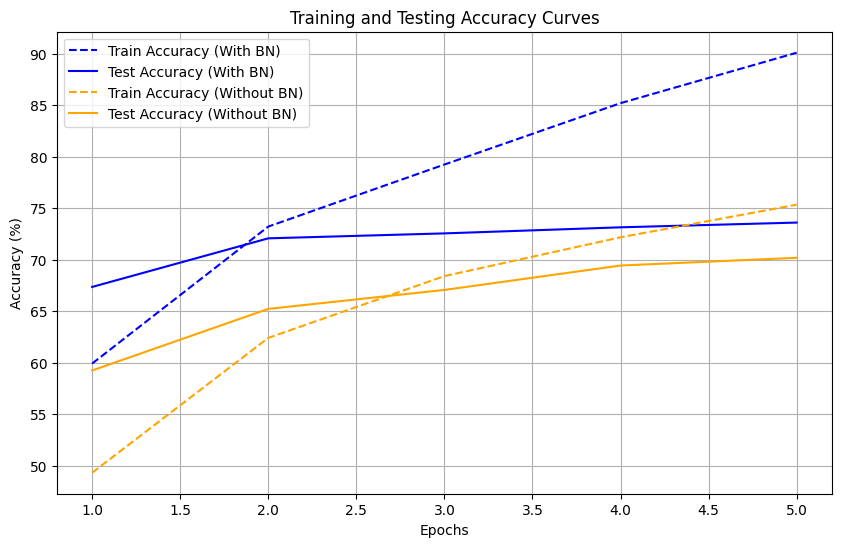

In [6]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc_with_bn) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_with_bn, label="Train Accuracy (With BN)", color="blue", linestyle="--")
plt.plot(epochs, test_acc_with_bn, label="Test Accuracy (With BN)", color="blue")
plt.plot(epochs, train_acc_without_bn, label="Train Accuracy (Without BN)", color="orange", linestyle="--")
plt.plot(epochs, test_acc_without_bn, label="Test Accuracy (Without BN)", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Testing Accuracy Curves")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
features = {}

def hook_function(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook


# For the model with Batch Norm
model_with_bn.conv1.register_forward_hook(hook_function("conv1_with_bn"))
model_with_bn.bn1.register_forward_hook(hook_function("bn1"))

# For the model without Batch Norm
model_without_bn.conv1.register_forward_hook(hook_function("conv1_without_bn"))

# Get a single test image
image, label = test_dataset[0]
image = image.unsqueeze(0).to(device)  # Add batch dimension

# Pass the image through the models
model_with_bn(image)
model_without_bn(image)

tensor([[-0.9929, -2.5548, -2.3975,  3.9625, -2.8873,  3.1585, -3.5538, -2.0154,
         -0.2941, -4.6336]], device='cuda:0', grad_fn=<AddmmBackward0>)

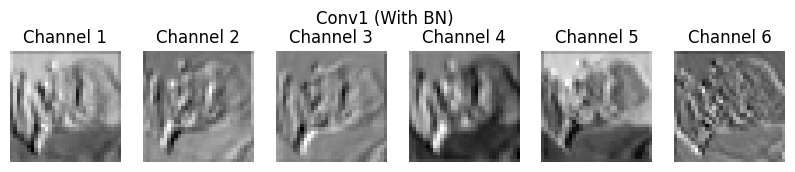

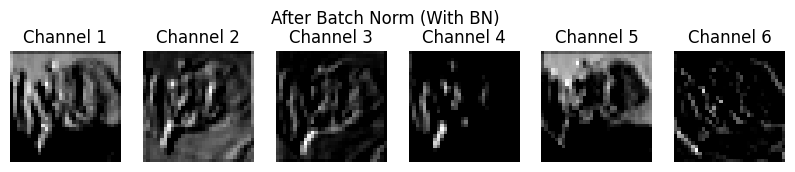

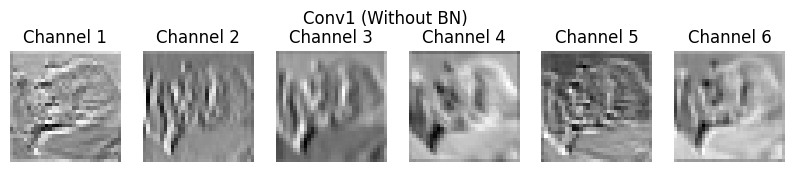

In [14]:
def visualize_features(features, title, num_channels=6):
    plt.figure(figsize=(10, 2))
    feature_maps = features.cpu().numpy()
    for i in range(num_channels):
        plt.subplot(1, num_channels, i + 1)
        plt.imshow(feature_maps[0, i], cmap="grey")
        plt.axis("off")
        plt.title(f"Channel {i+1}")
    plt.suptitle(title)
    plt.show()

# Visualize feature maps for model with Batch Norm
visualize_features(features["conv1_with_bn"], "Conv1 (With BN)")
visualize_features(features["bn1"], "After Batch Norm (With BN)")

# Visualize feature maps for model without Batch Norm
visualize_features(features["conv1_without_bn"], "Conv1 (Without BN)")


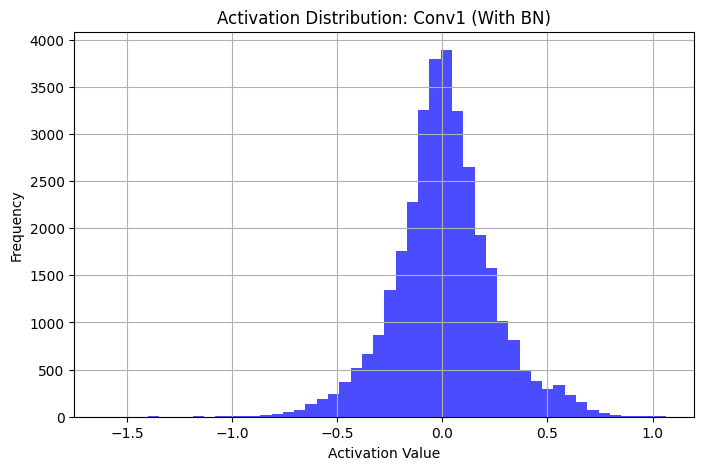

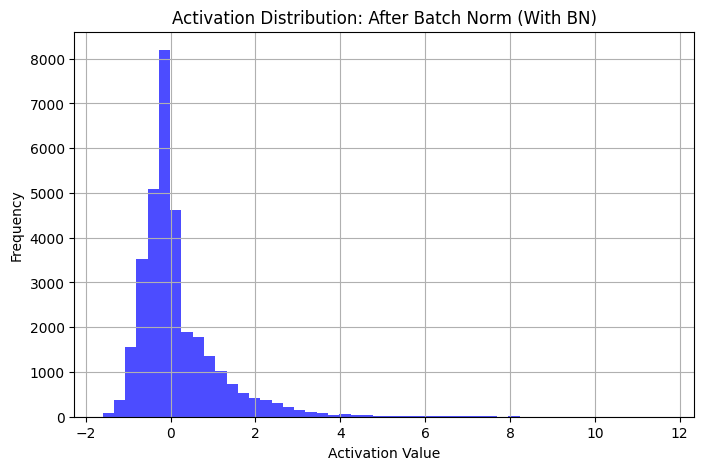

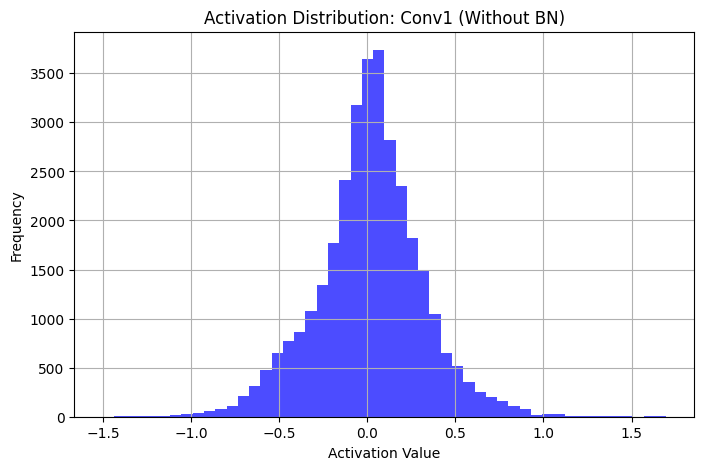

In [9]:
def plot_histogram(features, title):
    feature_data = features.flatten().cpu().numpy()
    plt.figure(figsize=(8, 5))
    plt.hist(feature_data, bins=50, alpha=0.7, color='blue')
    plt.title(title)
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Plot histograms for model with Batch Norm
plot_histogram(features["conv1_with_bn"], "Activation Distribution: Conv1 (With BN)")
plot_histogram(features["bn1"], "Activation Distribution: After Batch Norm (With BN)")

# Plot histograms for model without Batch Norm
plot_histogram(features["conv1_without_bn"], "Activation Distribution: Conv1 (Without BN)")